In [48]:
%run common.py

Planning start time: Jul 06, 07:35 (1467779708)


<a id='toc'></a>
## Содержание

1. [Вывозные локомотивы](#vyv)
2. [Сохранение времени явки бригады при перепланировании](#pr_save)

<a id='vyv'></a>
## Вывозные локомотивы [ToC](#toc)

### Задания

Войтенко/Фрольцову:
1. Составить список локомотивов, которые работают на Восточном полигоне в вывозном движении. Для каждого локомотива указать номер, серию, ЕСР-код и название депо приписки.

Вздыхалкину/Науменко:
1. Разработать сущность онтологии, в которой хранить список вывозных локомотивов.

Башанову/Каштанову:
1. Разработать форму в АРМе Технолога, в которой показывать вывозные локомотивы.
2. Реализовать возможность редактирования списка вывозных локомотивов через эту форму (добавление / удаление).

Костенко:
1. Загрузить исходный справочник вывозных локомотивов в разработанную сущность.
2. Передавать вывозные локомотивы в планировщик с типом 2.

Смилге:
1. Реализовать алгоритм планирования вывозных локомотивов в планировщике.

### Алгоритм планирования вывозных локомотивов

1.	Локомотивы с типом «Вывозной» (это локомотивы со значением атрибута type = 2 в сообщении loco_attributes) должны работать преимущественно на коротких локомотивных слотах. Такие локомотивы чаще всего используются для развоза поездов внутри одного-двух УОЛБов.
2.	По этому критерию локомотиву дается добавка в функцию полезности, если это вывозной локомотив, а время хода по локомотивному слоту – небольшое.
3.	В качестве «серединного» значения выбрано время хода в 16 часов. Это связано с тем, что время хода по одному УОЛБу – примерно 6-8 часов. Соответственно, при таком выборе «длинными» будут считаться маршруты длиннее двух УОЛБов.
4. При расчете функции полезности при назначении локомотива на поезд для вывозных локомотивов прибавлять слагаемое $f(t)=\frac{2}{1+\exp⁡{(k(t-t_0))}}-1$, где $t$ – время хода по всему локомотивному слоту, выраженное в часах, $t_0=16$. Слагаемое входит в выражение для функции полезности только для локомотивов с типом «вывозной».
4. Из графика этой функции (см. ниже) видно, что при небольших временах хода по слоту (до 10 часов) вывозным локомотивам будет, по сути, добавляться +1 в функцию полезности, а при больших временах (больше 20 часов) – добавляться -1. Такая модель будет соответствовать реальным требованиям к планированию.
6.	На картинке приведено семейство графиков в зависимости от значения коэффициента под экспонентой (k). В формуле выше этот коэффициент равен 1. Его значение влияет на то, насколько график будет растянут возле среднего значения времени хода. Предлагается выбрать значение $k = 1.0$, а затем поменять в случае необходимости. Видно, что при больших k будет уменьшаться длина слотов, для которых будет добавка +1, с увеличением длины эта добавка будет убывать быстрее.

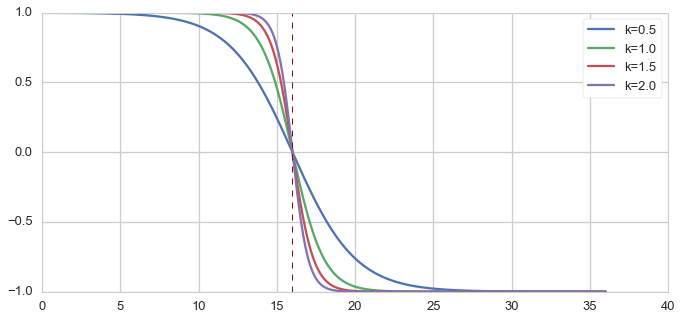

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

x0 = 16
x = np.linspace(0, 36, 1000)
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
for k in np.linspace(0.5, 2, 4):
    y = 2 / (1 + np.exp(k * (x - x0))) - 1
    plt.plot(x, y, label='k=%.1f' % k)
    
plt.plot([x0] * 20, np.linspace(-1, 1, 20), 'r--', lw=1.0)
plt.legend(frameon=True)
plt.show()

### Примеры планирования вывозных локомотивов

На плече Мариинск - Борзя работают вывозные локомотивы серии 2ЭС5К депо приписки Вихоревка. Эти локомотивы имеют номера от 80 до 87 включительно.

In [50]:
cols = ['loco', 'number', 'ser_name', 'depot_name', 'loc_name']
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info.ser_name.fillna('-1', inplace=True)
loco_info['depot_name'] = loco_info.depot.map(st_names.name)
vyv = loco_info[(loco_info.ser_name.apply(lambda x: 'ЭС5К' in x)) & (loco_info.depot_name == 'ВИХОРЕВКА')
          & (loco_info.number >= 80) & (loco_info.number < 88)].sort_values(['depot_name', 'number'])
#nice_print(vyv, cols=cols, num=True)
vyv[cols]

,loco,number,ser_name,depot_name,loc_name
1142,200200031392,80,2ЭС5К,ВИХОРЕВКА,ГОРХОН
1163,200200090764,82,2ЭС5К,ВИХОРЕВКА,КИТОЙ-КОМБИНАТСКАЯ - КИТОЙ
1576,200200090702,83,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ - БАТАРЕЙНАЯ
842,200200080455,84,2ЭС5К,ВИХОРЕВКА,КАСЬЯНОВКА - МАЛЬТА
1782,200200058242,85,2ЭС5К,ВИХОРЕВКА,ЗУЙ - СУХОВСКАЯ
900,200200058339,86,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ - ГОНЧАРОВО
808,200200056605,87,2ЭС5К,ВИХОРЕВКА,ЧИТА I - КАРЫМСКАЯ


In [51]:
cols = ['loco', 'number', 'ser_name', 'regions', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train']
loco_plan['ser_name'] = loco_plan.series.map(loco_series.set_index('ser_id').ser_name)
loco_plan['depot_name'] = loco_plan.depot.map(st_names.name)
a = loco_plan[loco_plan.loco.isin(vyv.loco)][cols]
start_st = a.drop_duplicates(subset=['loco', 'train'])
end_st = a.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)
trips

,loco,number,ser_name,regions,st_from_name,st_to_name,time_start,time_end,train,tt
0,200200031392,80,2ЭС5К,['2002119299'],ГОРХОН,УЛАН-УДЭ,1467782100,1467788916,210256220314,1.89
2,200200090764,82,2ЭС5К,['2002119299'],КИТОЙ-КОМБИНАТСКАЯ,СЛЮДЯНКА II,1467781200,1467805197,210256459842,6.67
1,200200090702,83,2ЭС5К,['2002119299'],ИРКУТСК-СОРТИРОВОЧНЫЙ,ЧЕРЕМХОВО,1467781500,1467797933,210256461742,4.56
5,200200080455,84,2ЭС5К,['2002119299'],КАСЬЯНОВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ,1467777720,1467792492,210256397500,4.10
4,200200058242,85,2ЭС5К,['2002119299'],ЗУЙ,СУХОВСКАЯ,1467780900,1467781440,210256460788,0.15
3,200200056605,87,2ЭС5К,"['2002119301', '2002119299']",ЧИТА I,КАРЫМСКАЯ,1467766740,1467774681,210254435608,2.21


Выводы:

1. Вывозные локомотивы и без доработок не планируются на дальние расстояния. Это странно. Время хода таких локомотивов (столбец tt) не превышает 7 часов.

<a id='pr_save'></a>
## Сохранение времени явки бригады при перепланировании [ToC](#toc)

Для бригад, которые были запланированы на предыдущем запуске, будет передаваться ранее запланированное время явки $t_{prev}$. Если бригада была запланирована на явку ранее в достаточно близком горизонте от времени запуска планировщика, то ей нельзя сильно менять время явки, поскольку она, скорее всего, уже находится в пути из дома в депо, и мы не можем просто так заставить ее сидеть в ожидании поезда еще несколько часов или же заставлять отправляться раньше уже запланированного времени.

Предложения по доработке такие:

1. Назовем "пред-бригадой" бригаду, для которой передано $t_{prev}$.
2. Если для пред-бригады передано исходное состояние $state \neq 3$, то планировать ее по обычному алгоритму (т.к. она уже вышла на работу, для нее уже есть фактическая явка).
3. Если для пред-бригады передано исходное состояние $state = 3$, то устанавливать для нее $state = 2$ с временем явки = $t_{prev}$.
4. Для бригад со $state = 2$ ввести дополнительное слагаемое в функции полезности, которое бы сильно штрафовало за подвязку с локомотивам с поздним временем отправления (если бригада будет ждать локомотив) и сильно бы повышало полезность за подвязку к уже готовым к отправлению локомотивам. В этом случае бригада со $state = 2$ будет скорее подвязываться под готовые локомотивы и не будет сильно задерживаться на станции.
5. Предлагается в качестве этого слагаемого брать значение $u(t) = \frac{2}{1 + \exp{k(t-t_0-\Delta)}} - 1$
6. Параметры этой функции: 
  1. $t_0$ - время явки бригады (из сообщения fact_team_ready или $t_{prev}$ из сообщения о пред-бригаде)
  2. $\Delta$ - допустимое отклонение от времени явки бригады. Оно зависит от "горизонта явки бригады":
    1. Если $t_0$ лежит на горизонте 3 часов от начала планирования, то $\Delta = 0.25$;
    2. Если $t_0$ лежит на горизонте 6 часов от начала планирования, то $\Delta = 0.5$;
    3. Если $t_0$ лежит на горизонте 12 часов от начала планирования, то $\Delta = 1.0$;    
  2. $k \approx \frac{10}{\Delta}$
  
7. TODO: Додумать такой момент: явку не двигать, но время отправления поезда сдвигать можно. Узнать у технологов, на сколько время отправления может быть позже времени явки.

k_opt = 30.4036, k_round = 40.00


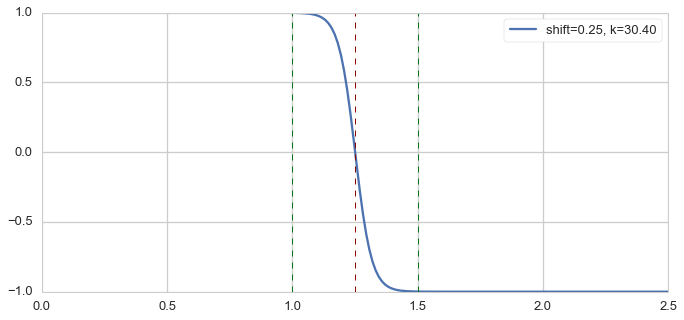

In [52]:
shift = 0.25
precision = 200
epsilon = 0.001
t_pres = 1
k_opt = np.log(2 / epsilon) / shift
k_round = 10 / shift
print('k_opt = %.4f, k_round = %.2f' % (k_opt, k_round))

x = np.linspace(-0, 2.5, precision)
y = 2/(1 + np.exp(k_opt * ((x - t_pres) - shift))) - 1
yc = np.linspace(-1, 1, precision)
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
plt.plot(x, y, label='shift=%.2f, k=%.2f' % (shift, k_opt))
plt.plot([t_pres + shift] * precision, yc, 'r--', lw=1.0)
plt.plot([t_pres] * precision, yc, 'g--', lw=1.0)
plt.plot([t_pres + 2 * shift] * precision, yc, 'g--', lw=1.0)    
plt.legend(frameon=True)
plt.show()

## Планирование ухода локомотивов на ТО

Сейчас, чтобы отправить локомотив на ТО, нам надо выждать один фрейм. Сначала мы планируем подвязку на фрейме, потом определяем, что какие-то локомотивы не подвязались, проверяем, что у этих локомотивов подходит время до ТО (!! найти в джире, как это проверяется, какая граница). Только потом отправляем эти локомотивы на ТО. При этом может возникнуть ситуация, что под поезда, которые находятся на одной станции с такими локомотивами, мы гоним резервом локомотивы с других станций. Так что когда локомотив выйдет с ТО, он еще и останется без работы.

TODO:

1. Проанализировать в планах время между прибытием локомотива на станцию и началом проведения ТО.
2. Найти случаи, когда под поезд гонится локомотив с других станций. Проанализировать расстояния, на которые гонится локомотив.
3. Написать постановку Боре на доработки планирования ТО.

## Планирование пересылок резервом

Есть случаи очень дальней пересылки локомотивов резервом. Такая пересылка нерациональна: за те много часов, которые локомотив едет, может случиться что угодно - и локомотив уже окажется ненужным. Поэтому предлагается ограничить "окно" пересылки локомотивов резервом: искать локомотивы только на станциях, до которых ехать сравнительно недолго. В качестве такого окна предлагается взять 16 часов, затем корректировать при необходимости.

TODO:

1. Сделать анализ расстояний (=времен хода), на которые планируется пересылка локомотивов резервом.
2. Выбрать граничное значение для окна поиска локомотива.
3. Написать постановку Боре на доработки планирования ТО.
  1. Отдельно выделить требование ограничить маршрут пересылки локомотива резервом только тяговыми плечами этого локомотива.